In [1]:
import os, sys, gzip
import numpy as np
from six.moves import cPickle
sys.setrecursionlimit(10000)

from lasagne import layers, nonlinearities, updates, objectives, init 
from lasagne.layers import get_output, get_output_shape, get_all_params
import theano.tensor as T
import theano
from theano.tensor.shared_randomstreams import RandomStreams
from lasagne.layers import Conv2DLayer, DenseLayer, InputLayer, ExpressionLayer, BiasLayer
from lasagne.layers import NonlinearityLayer, MaxPool2DLayer, DropoutLayer, BatchNormLayer

sys.path.append('..')
from src import NeuralNet
from src import train as fit
from src import make_directory 
from models import load_model
from data import load_data

from subprocess import call

#np.random.seed(247) # for reproducibility

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
%matplotlib inline
from scipy.misc import imresize

datadir = '/home/peter/Data/SequenceMotif/networkcomparison3'
savedir = make_directory(datadir, 'local_basset')

from tsne import bh_sne
from subprocess import call

Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)


In [2]:
filename = 'Localized_N=100000_S=200_M=50_G=20_data.pickle'
datapath = '/home/peter/Data/SequenceMotif'
filepath = os.path.join(datapath, filename)

# load training set
print "loading data from: " + filepath
f = open(filepath, 'rb')
print "loading train data"
train = cPickle.load(f)
print "loading cross-validation data"
cross_validation = cPickle.load(f)
print "loading test data"
test = cPickle.load(f)
f.close()

X_train = train[0].transpose((0,1,2)).astype(np.float32)
y_train = train[1].astype(np.int32)
X_val = cross_validation[0].transpose((0,1,2)).astype(np.float32)
y_val = cross_validation[1].astype(np.int32)
X_test = test[0].transpose((0,1,2)).astype(np.float32)
y_test = test[1].astype(np.int32)

X_train = np.expand_dims(X_train, axis=3)
X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)

train = (X_train, y_train, train[2])
valid = (X_val, y_val, cross_validation[2])
test = (X_test, y_test, test[2])

shape = (None, train[0].shape[1], train[0].shape[2], train[0].shape[3])
num_labels = train[1].shape[1]

loading data from: /home/peter/Data/SequenceMotif/Localized_N=100000_S=200_M=50_G=20_data.pickle
loading train data
loading cross-validation data
loading test data


In [3]:
model_name = "test_motif_model"
nnmodel = NeuralNet(model_name, shape, num_labels)

In [4]:
nnmodel = fit.train_minibatch(nnmodel, train, valid, batch_size=128, num_epochs=500, 
                        patience=3, verbose=1, filepath=filepath)

Epoch 1 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.04033 -- accuracy=98.69%  
  valid loss:		0.01094
  valid accuracy:	0.99630+/-0.00357
  valid auc-roc:	0.99901+/-0.00126
  valid auc-pr:		0.96722+/-0.07973
saving model parameters to: /home/peter/Data/SequenceMotif/Localized_N=100000_S=200_M=50_G=20_data.pickle_epoch_0.pickle
Epoch 2 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.00662 -- accuracy=99.78%  
  valid loss:		0.00917
  valid accuracy:	0.99686+/-0.00318
  valid auc-roc:	0.99947+/-0.00069
  valid auc-pr:		0.98251+/-0.04103
saving model parameters to: /home/peter/Data/SequenceMotif/Localized_N=100000_S=200_M=50_G=20_data.pickle_epoch_1.pickle
Epoch 3 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.00275 -- accuracy=99.91%  
  valid loss:		0.00961
  valid accuracy:	0.99708+/-0.00316
  valid auc-roc:	0.99946+/-0.00067
  valid auc-pr:		0.98722+/-0.02593
saving model parameters to: /home/peter/Data/Se

In [5]:
# save best model --> lowest cross-validation error
min_loss, min_index = nnmodel.get_min_loss()
savepath = filepath + "_epoch_" + str(min_index) + ".pickle"
nnmodel.set_parameters_from_file(savepath)


In [6]:
# test model
nnmodel.test_model(test, 512, "test")

  test loss:		0.00899
  test accuracy:	0.99704+/-0.00306
  test auc-roc:	0.99945+/-0.00060
  test auc-pr:		0.98126+/-0.04101


0.0089857738829530933

In [7]:
network = nnmodel.network
network

{'conv1': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7f5c59d58650>,
 'conv1_active': <lasagne.layers.special.NonlinearityLayer at 0x7f5c59d58bd0>,
 'conv1_batch': <lasagne.layers.normalization.BatchNormLayer at 0x7f5c59d58790>,
 'conv1_bias': <lasagne.layers.special.BiasLayer at 0x7f5c59d58690>,
 'conv1_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7f5c59d58d50>,
 'conv2': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7f5c59d5d610>,
 'conv2_active': <lasagne.layers.special.NonlinearityLayer at 0x7f5c59d5dc90>,
 'conv2_batch': <lasagne.layers.normalization.BatchNormLayer at 0x7f5c59d5d790>,
 'conv2_bias': <lasagne.layers.special.BiasLayer at 0x7f5c59d5d650>,
 'conv2_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7f5c59d5d5d0>,
 'dense2': <lasagne.layers.dense.DenseLayer at 0x7f5c59d672d0>,
 'dense2_active': <lasagne.layers.special.NonlinearityLayer at 0x7f5c59d67450>,
 'dense2_bias': <lasagne.layers.special.BiasLayer at 0x7f5ceb5c1cd0>,
 'dense2_dropout': <lasagne.layers.noise.DropoutLayer at

In [8]:
import pandas as pd
def seq_logo(pwm, height=100, nt_width=20, norm=0, rna=1, filepath='.'):
    """generate a sequence logo from a pwm"""
    
    def load_alphabet(filepath, rna):
        """load images of nucleotide alphabet """
        df = pd.read_table(os.path.join(filepath, 'A.txt'), header=None);
        A_img = df.as_matrix()
        A_img = np.reshape(A_img, [72, 65, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'C.txt'), header=None);
        C_img = df.as_matrix()
        C_img = np.reshape(C_img, [76, 64, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'G.txt'), header=None);
        G_img = df.as_matrix()
        G_img = np.reshape(G_img, [76, 67, 3], order="F").astype(np.uint8)

        #if rna == 1:
        #    df = pd.read_table(os.path.join(filepath, 'U.txt'), header=None);
        #    T_img = df.as_matrix()
        #    T_img = np.reshape(T_img, [74, 57, 3], order="F").astype(np.uint8)
        #else:
        df = pd.read_table(os.path.join(filepath, 'T.txt'), header=None);
        T_img = df.as_matrix()
        T_img = np.reshape(T_img, [72, 59, 3], order="F").astype(np.uint8)

        return A_img, C_img, G_img, T_img


    def get_nt_height(pwm, height, norm):
        """get the heights of each nucleotide"""

        def entropy(p):
            """calculate entropy of each nucleotide"""
            s = 0
            for i in range(4):
                if p[i] > 0:
                    s -= p[i]*np.log2(p[i])
            return s

        num_nt, num_seq = pwm.shape
        heights = np.zeros((num_nt,num_seq));
        for i in range(num_seq):
            if norm == 1:
                total_height = height
            else:
                total_height = (np.log2(4) - entropy(pwm[:, i]))*height;
            heights[:,i] = np.floor(pwm[:,i]*total_height);
        return heights.astype(int)

    
    # get the alphabet images of each nucleotide
    A_img, C_img, G_img, T_img = load_alphabet(filepath='.', rna=1)
    
    
    # get the heights of each nucleotide
    heights = get_nt_height(pwm, height, norm)
    
    # resize nucleotide images for each base of sequence and stack
    num_nt, num_seq = pwm.shape
    width = np.ceil(nt_width*num_seq).astype(int)
    
    total_height = np.sum(heights,axis=0)
    max_height = np.max(total_height)
    logo = np.ones((height*2, width, 3)).astype(int)*255;
    for i in range(num_seq):
        remaining_height = total_height[i];
        offset = max_height-remaining_height
        nt_height = np.sort(heights[:,i]);
        index = np.argsort(heights[:,i])

        for j in range(num_nt):
            if nt_height[j] > 0:
                # resized dimensions of image
                resize = (nt_height[j], nt_width)
                if index[j] == 0:
                    nt_img = imresize(A_img, resize)
                elif index[j] == 1:
                    nt_img = imresize(C_img, resize)
                elif index[j] == 2:
                    nt_img = imresize(G_img, resize)
                elif index[j] == 3:
                    nt_img = imresize(T_img, resize)

                # determine location of image
                height_range = range(remaining_height-nt_height[j], remaining_height)
                width_range = range(i*nt_width, i*nt_width+nt_width)

                # 'annoying' way to broadcast resized nucleotide image
                if height_range:
                    for k in range(3):
                        for m in range(len(width_range)):
                            logo[height_range+offset, width_range[m],k] = nt_img[:,m,k];

                remaining_height -= nt_height[j]

    return logo.astype(np.uint8)


In [9]:
def fig_options(plt, options):
    if 'figsize' in options:
        fig = plt.gcf()
        fig.set_size_inches(options['figsize'][0], options['figsize'][1], forward=True)
    if 'ylim' in options:
        plt.ylim(options['ylim'][0],options['ylim'][1])
    if 'yticks' in options:
        plt.yticks(options['yticks'])
    if 'xticks' in options:
        plt.xticks(options['xticks'])
    if 'labelsize' in options:        
        ax = plt.gca()
        ax.tick_params(axis='x', labelsize=options['labelsize'])
        ax.tick_params(axis='y', labelsize=options['labelsize'])
    if 'axis' in options:
        plt.axis(options['axis'])
    if 'xlabel' in options:
        plt.xlabel(options['xlabel'], fontsize=options['fontsize'])
    if 'ylabel' in options:
        plt.ylabel(options['ylabel'], fontsize=options['fontsize'])
    if 'linewidth' in options:
        plt.rc('axes', linewidth=options['linewidth'])
        

def subplot_grid(nrows, ncols):
    grid= mpl.gridspec.GridSpec(nrows, ncols)
    grid.update(wspace=0.2, hspace=0.2, left=0.1, right=0.2, bottom=0.1, top=0.2) 
    return grid


def get_feature_maps(layer, X, input_var, batch_size=500):
    """get the feature maps of a given convolutional layer"""

    # setup theano function to get feature map of a given layer
    num_data = len(X)
    feature_maps = theano.function([input_var], layers.get_output(layer, deterministic=True), allow_input_downcast=True)
    map_shape = get_output_shape(layer)

    # get feature maps in batches for speed (large batches may be too much memory for GPU)
    num_batches = num_data // batch_size
    shape = list(map_shape)
    shape[0] = num_data
    fmaps = np.empty(tuple(shape))
    for i in range(num_batches):
        index = range(i*batch_size, (i+1)*batch_size)    
        fmaps[index] = feature_maps(X[index])

    # get the rest of the feature maps
    excess = num_data-num_batches*batch_size
    index = range(num_data-excess, num_data)    
    fmaps[index] = feature_maps(X[index])
    
    return fmaps



def tSNE_plot(vis_data, labels):
    """scatter plot of tSNE 2D projections, with a color corresponding to labels"""
    num_labels = max(labels)+1
    vis_x = vis_data[:,0]
    vis_y = vis_data[:,1]
    plt.figure(figsize = (10,10))
    fig = plt.gcf()
    fig.set_size_inches(50, 50, forward=True)
    plt.scatter(vis_x, vis_y, c=labels, cmap=plt.cm.get_cmap("jet", num_labels),  edgecolor = 'none')
    plt.axis('off')
    return plt



def get_class_activation(fmaps, y, batch_size=512):
    fmaps = np.squeeze(fmaps)
    mean_activation = []
    std_activation = []
    for i in range(max(y)+1):
        index = np.where(y == i)[0]
        mean_activation.append(np.mean(fmaps[index], axis=0))
        std_activation.append(np.std(fmaps[index], axis=0))
    return np.array(mean_activation), np.array(std_activation)


def plot_mean_activations(mean_activation, options):
    num_labels = len(mean_activation)
    nrows = np.ceil(np.sqrt(num_labels)).astype(int)
    ncols = nrows

    plt.figure()
    grid = subplot_grid(nrows, ncols)
    for i in range(num_labels):
        plt.subplot(grid[i])
        plt.plot(mean_activation[i].T)
        fig_options(plt, options)
    return plt


def plot_conv_filter(layer,size):
    W =  np.squeeze(layer.W.get_value())
    num_filters = W.shape[0]

    num_rows = int(np.ceil(np.sqrt(num_filters)))    
    grid = mpl.gridspec.GridSpec(num_rows, num_rows)
    grid.update(wspace=0.2, hspace=0.2, left=0.1, right=0.2, bottom=0.1, top=0.2) 
    
    fig = plt.figure(figsize=size);
    for i in range(num_filters):
        MAX = np.max(W[i])
        pwm = W[i]/MAX
        pwm += .2
        pwm[pwm<0] = 0
        norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
        pwm = pwm/norm

        logo = seq_logo(pwm, height=100, nt_width=25, norm=0, rna=0, filepath='.')
        plt.subplot(grid[i]);
        plt.imshow(logo);
        plt.axis('off');
    return fig, plt



#### 1st shallow layer

In [10]:
def meme_generate(filename, W, prefix='filter', norm=False):
    nt_freqs = [1./4 for i in range(4)]

    # open file for writing
    f = open(filename, 'w')

    # print intro material
    print >> f, 'MEME version 4'
    print >> f, ''
    print >> f, 'ALPHABET= ACGT'
    print >> f, ''
    print >> f, 'Background letter frequencies:'
    print >> f, 'A %.4f C %.4f G %.4f T %.4f' % tuple(nt_freqs)
    print >> f, ''

    for j in range(len(W)):
        if norm:
            MAX = np.max(W[j])
            pwm = W[j]/MAX
            pwm += .2
            pwm[pwm<0] = 0.001
            N = np.sum(pwm, axis=0)
            N[N==0]= 1
            Z = np.outer(np.ones(4), N)
            pwm = pwm/Z
            
        else:
            pwm = W[j]

        print >> f, 'MOTIF %s%d' % (prefix, j)
        print >> f, 'letter-probability matrix: alength= 4 w= %d nsites= %d' % (pwm.shape[1], 7)
        for i in range(pwm.shape[1]):
            print >> f, '%.4f %.4f %.4f %.4f' % tuple(pwm[:,i])
        print >> f, ''

    f.close()
    
    
W =  np.squeeze(network['conv1'].W.get_value())
savepath = os.path.join(savedir, 'filters_meme.txt')
meme_generate(savepath, W, prefix='filter', norm=True)


In [11]:
filename = 'Unlocalized_N=100000_S=200_M=50_G=20_model.pickle'
datapath = '/home/peter/Data/SequenceMotif'
filepath = os.path.join(datapath, filename)

# load training set
print "loading data from: " + filepath
f = open(filepath, 'rb')
options = cPickle.load(f)
model = cPickle.load(f)
seq_model = cPickle.load(f)
f.close()

motifs = model[0]
motif_interaction = model[1]

index = np.empty(1)
for i in range(len(motif_interaction)):
    index = np.hstack([index, motif_interaction[i]])
motif_index = np.unique(index[1:]).astype(int)
motif_index.shape

database = []
for i in range(len(motif_index)):
    database.append(motifs[motif_index[i]].as_matrix())
    
savepath = os.path.join(savedir, 'database_meme_exact.txt')
meme_generate(savepath, database, prefix='filter', norm=False)


loading data from: /home/peter/Data/SequenceMotif/Unlocalized_N=100000_S=200_M=50_G=20_model.pickle


In [12]:
get_output_shape(nnmodel.network['conv2'])

(None, 150, 8, 1)

/home/peter/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


0

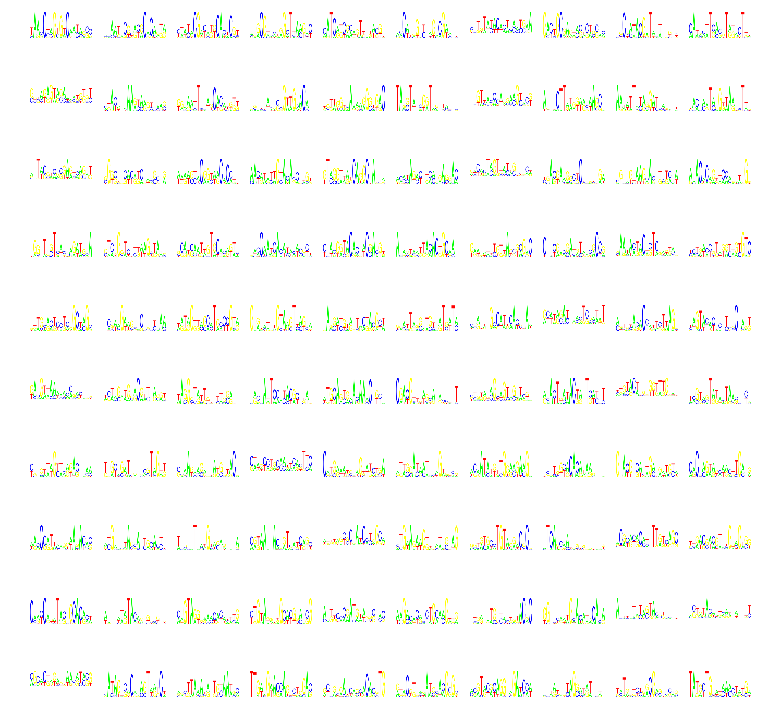

In [13]:
# plot convolution filters

fig, plt = plot_conv_filter(network['conv1'],size=(100.,100.))
fig.set_size_inches(100,100)
outfile = os.path.join(savedir,'shallow_layer1_filters.pdf')
fig.savefig(outfile, format='pdf', dpi=1000)  
call(['pdfcrop', outfile, outfile])

0

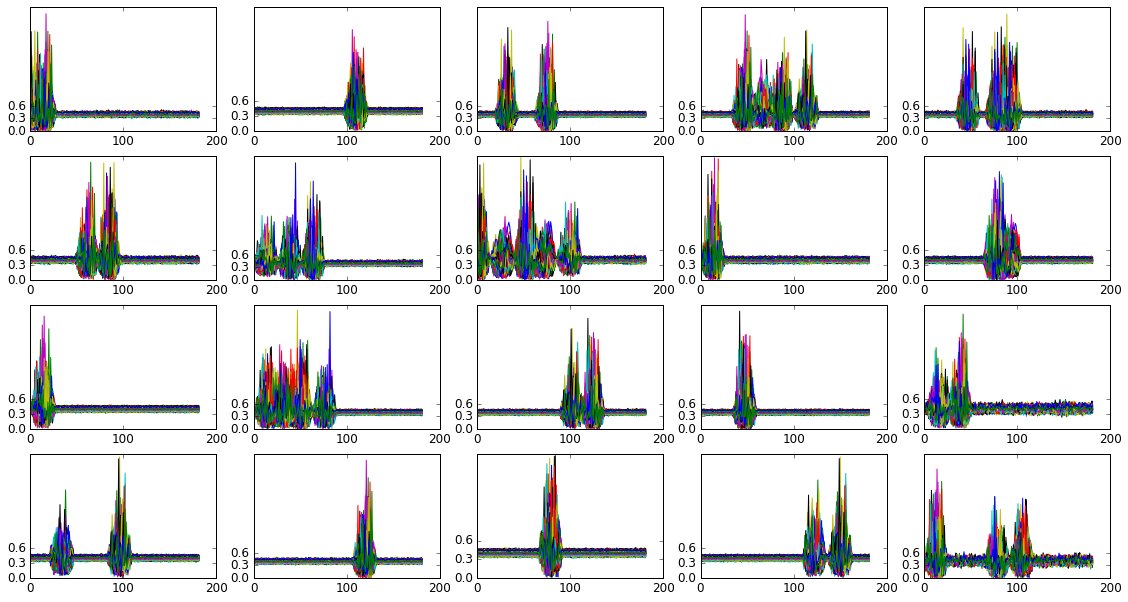

In [14]:
# plot mean activation
fmaps = get_feature_maps(network['conv1_active'], train[0], nnmodel.input_var, batch_size=512) 
mean_activation, std_activation = get_class_activation(fmaps, np.argmax(train[1],axis=1))
options = { 'xlim': [0, get_output_shape(network['conv1_active'])[2]],
            'xticks': [0, 100, 200],
           'yticks': [0,.3, .6],
            'labelsize': 12,
            'figsize': (150,100)}
plt = plot_mean_activations(mean_activation, options)
outfile = os.path.join(savedir,'shallow_layer1_activation.pdf')
plt.savefig(outfile, format='pdf', dpi=1000)    
call(['pdfcrop', outfile, outfile])

In [ ]:
fig = plt.figure()
plt.plot(train[2][0].T);
outfile = os.path.join(savedir,'individual_model.pdf')
plt.savefig(outfile, format='pdf', dpi=1000)    
call(['pdfcrop', outfile, outfile])


In [ ]:
# plot individual activations
index = 0
individual = np.squeeze(fmaps[index])
fig = plt.figure()
plt.plot(individual.T)
outfile = os.path.join(savedir,'individual_layer1_activation.pdf')
plt.savefig(outfile, format='pdf', dpi=1000)    
call(['pdfcrop', outfile, outfile])


In [ ]:
"""
fmaps = train[0].astype(np.float64)

# t-SNE 
fmaps_flat = fmaps.reshape((len(fmaps),-1))
fmaps_flat.shape

# perform t-SNE embedding
vis_cnn = bh_sne(fmaps_flat)

In [ ]:
"""
options = {'figsize':(5,5), 'axis':'off'}
plt = tSNE_plot(vis_cnn, np.argmax(train[1],axis=1))
outfile = os.path.join(savedir,'shallow_layer0_tSNE.pdf')
plt.savefig(outfile, format='eps', dpi=1000)    
call(['pdfcrop', outfile, outfile])

## 2nd shallow layer

In [ ]:
layer = network['conv2_pool']
X = train[0]
input_var = nnmodel.input_var
batch_size = 512

# setup theano function to get feature map of a given layer
num_data = len(X)
feature_maps = theano.function([input_var], layers.get_output(layer), allow_input_downcast=True)
map_shape = get_output_shape(layer)

# get feature maps in batches for speed (large batches may be too much memory for GPU)
num_batches = num_data // batch_size
shape = list(map_shape)
shape[0] = num_data
fmaps = np.empty(tuple(shape))
for i in range(num_batches):
    index = range(i*batch_size, (i+1)*batch_size)    
    fmaps[index] = feature_maps(X[index])


In [ ]:
# t-SNE 
fmaps_flat = fmaps.reshape((len(fmaps),-1))
fmaps_flat.shape

# perform t-SNE embedding
vis_cnn = bh_sne(fmaps_flat)

In [ ]:
options = {'figsize':(5,5), 'axis':'off'}
plt = tSNE_plot(vis_cnn, np.argmax(train[1],axis=1))
outfile = os.path.join(savedir,'shallow_layer2_tSNE.pdf')
plt.savefig(outfile, format='eps', dpi=1000)    
call(['pdfcrop', outfile, outfile])

## 3rd convolutional layer

In [ ]:
# plot mean activation
fmaps = get_feature_maps(network['conv3_active'], train[0], nnmodel.input_var, batch_size=512) 
# t-SNE 
fmaps_flat = fmaps.reshape((len(fmaps),-1))
fmaps_flat.shape

# perform t-SNE embedding
vis_cnn = bh_sne(fmaps_flat)

In [ ]:
options = {'figsize':(5,5), 'axis':'off'}
plt = tSNE_plot(vis_cnn, np.argmax(train[1],axis=1))
outfile = os.path.join(savedir,'shallow_layer3_tSNE.pdf')
plt.savefig(outfile, format='eps', dpi=1000)    
call(['pdfcrop', outfile, outfile])

## dense layer

In [ ]:
# plot mean activation
fmaps = get_feature_maps(network['dense1_active'], train[0], nnmodel.input_var, batch_size=512) 
# t-SNE 
fmaps_flat = fmaps.reshape((len(fmaps),-1))
fmaps_flat.shape

# perform t-SNE embedding
vis_cnn = bh_sne(fmaps_flat)

In [ ]:
options = {'figsize':(5,5), 'axis':'off'}
plt = tSNE_plot(vis_cnn, np.argmax(train[1],axis=1))
outfile = os.path.join(savedir,'shallow_layer4_tSNE.pdf')
plt.savefig(outfile, format='eps', dpi=1000)    
call(['pdfcrop', outfile, outfile])